# Lab 3 — recommender systems

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import math
import pickle
import pandas as pd

from operator import itemgetter

from operator import add
from collections import Counter

from bokeh.io import show, output_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool, ResetTool, PanTool, WheelZoomTool, SaveTool
from bokeh.models import ColumnDataSource, Range1d, LabelSet, Label

In [2]:
%matplotlib inline
plt.style.use("ggplot")

output_notebook()

sqlContext = SQLContext(sc)

Loading BokehJS ...

What does the data look like?

In [3]:
!hdfs dfs -cat /ix/ml-20m/ratings.txt | tail -n 2

{"movieId": 70286, "userId": 138493, "timestamp": 1258126944, "rating": 5.0}
{"movieId": 71619, "userId": 138493, "timestamp": 1255811136, "rating": 2.5}


## Exercise 3.4

In [4]:
data = sc.textFile("/ix/ml-20m/ratings.txt").map(json.loads)

In [5]:
# Compute the number of ratings for each user/movie
userToNRatings = data.map(lambda x: (x["userId"], 0)).countByKey()
movieToNRatings = data.map(lambda x: (x["movieId"], 0)).countByKey()

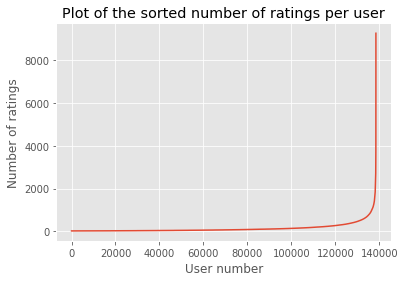

In [6]:
plt.plot(sorted(userToNRatings.values()))
plt.title("Plot of the sorted number of ratings per user")
plt.xlabel("User number")
plt.ylabel("Number of ratings")
plt.show()

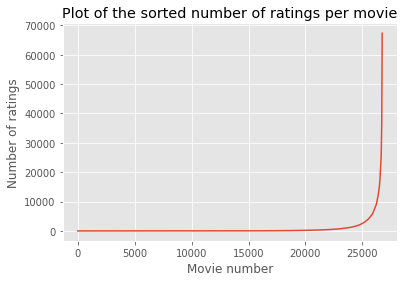

In [7]:
plt.plot(sorted(movieToNRatings.values()))
plt.title("Plot of the sorted number of ratings per movie")
plt.xlabel("Movie number")
plt.ylabel("Number of ratings")
plt.show()

From the ratings graph it is quite clear that most of the ratings are left by few users and that few movies get most of the ratings. The distributions of the number of ratings for users and movies look very similar.

In [8]:
# Count the number of ratings and sum all the ratings
c,s = data.aggregate((0,0), lambda a,b: (a[0]+1, a[1] + b['rating']), lambda a,b: (a[0]+b[0], a[1]+b[1]))
print(c, s)

20000263 70511498.5


In [9]:
# Compute the average rating
totalAverageRating = s/c
print(totalAverageRating)

3.5255285642993797


## Exercise 3.5

In [10]:
# Split the data into training set (80%) and validation set(20%) based on the timestamp
trainingSet = data.filter(lambda x: (x["timestamp"] % 5 != 0))
validationSet = data.filter(lambda x: (x["timestamp"] % 5 == 0))

## Exercise 3.6

In [11]:
# Aggregation functions to compute the sum of the ratings for each user and returning them as a dict

# Add the rating to the sum for the user
def f(a,b):
    rating = b["rating"]
    current = a.get(b["userId"], -1)
    if (current == -1):
        a[b["userId"]] = 0
    
    a[b["userId"]] += rating
    return a

# Add two dict accumulators
def g(a,b):
    if ((isinstance(b,dict)) & (isinstance(a,dict))):
        for k,v in b.items():
            current = a.get(k, -1)
            if (current == -1):
                a[k] = v
            else:
                a[k] += v

    return a

In [12]:
trainingUsersRatingSums = trainingSet.aggregate(dict(), f, g)

In [13]:
# Compute the user biases from the sum of their ratings
trainingUsersRatingBiases = {}

for k,v in trainingUsersRatingSums.items():
    trainingUsersRatingBiases[k] = (v / userToNRatings[k]) - totalAverageRating
    
print(trainingUsersRatingBiases[138493])

-0.03223097716801249


In [14]:
avgUserBias = sum(trainingUsersRatingBiases.values()) / len(trainingUsersRatingBiases)

In [15]:
# Change the element function of the aggregation to sum movie ratings
def f(a,b):
    rating = b["rating"]
    current = a.get(b["movieId"], -1)
    if (current == -1):
        a[b["movieId"]] = 0
    
    a[b["movieId"]] += rating - trainingUsersRatingBiases[b["userId"]]
    return a

trainingMoviesSums = trainingSet.aggregate(dict(), f, g)

In [16]:
# Compute the movie biases from their rating sums

trainingMovieBiases = {}

for k,v in trainingMoviesSums.items():
    trainingMovieBiases[k] = (v / movieToNRatings[k]) - totalAverageRating

In [17]:
avgMovieBias = sum(trainingMovieBiases.values()) / len(trainingMovieBiases)

## Excercise 3.7

In [18]:
# Takes a dictionary type rdd and compares it against the simple prediction model
def error(data, user="userId", product="movieId", rating="rating"):
    
    # Change the aggregation element function to compute the sum of square errors for the predicted ratings of the movies
    def f(a,b):
        r = b[rating]
        current = a.get(b[user], -1)
        if (current == -1):
            a[b[user]] = 0
        
        # Use the average movie/user bias if none is available
        mBias = trainingMovieBiases.get(b[product], avgMovieBias)
        uBias = trainingUsersRatingBiases.get(b[user], avgUserBias)
        err = r - (totalAverageRating + mBias + uBias)
        
        a[b[user]] += err * err
        return a

    errorSums = data.aggregate(dict(), f, g)
    errorAverages = {}

    for k,v in errorSums.items():
        errorAverages[k] = math.sqrt(v / userToNRatings[k])
        
    return sum(errorAverages.values()) / len(errorAverages)

In [19]:
error(validationSet)

0.5694905425665281

## Exercise 3.8

In [20]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

In [21]:
# Takes a tuple type rdd containing the ALS predictions and compares against the validation set.
def errorTuples(data, comp):
    
    # Change the aggregation element function to compute the sum of square errors for the predicted ratings of the movies
    def f(a,b):
        r = b[2]
        current = a.get(b[0], -1)
        if (current == -1):
            a[b[0]] = 0
        
        # Use the average movie/user bias if none is available
        mBias = trainingMovieBiases.get(b[1], avgMovieBias)
        uBias = trainingUsersRatingBiases.get(b[0], avgUserBias)
        err = r - comp[(b[0], b[1])]
        
        a[b[0]] += err * err
        return a

    errorSums = data.aggregate(dict(), f, g)
    errorAverages = {}

    for k,v in errorSums.items():
        errorAverages[k] = math.sqrt(v / userToNRatings[k])
        
    return sum(errorAverages.values()) / len(errorAverages)

In [22]:
# Get the validation set in a format that  is easier to work with
comp = dict(validationSet.map(lambda l: ((l['userId'], l['movieId']), l['rating'])).collect())

In [23]:
# Given rank, numIterations and lambda compute the error of an ALS model
def evaluateModel(rank, numIterations, lmbda):
    # Load and parse the data
    ratings = trainingSet.map(lambda l: Rating(l['userId'], l['movieId'], l['rating']))
    testdata = validationSet.map(lambda l: (l['userId'], l['movieId']))
    # Build the recommendation model using Alternating Least Squares
    model = ALS.train(ratings, rank, numIterations, lmbda)

    # Evaluate the model on training data
    predictions = model.predictAll(testdata)
    return errorTuples(predictions, comp)

In [24]:
evaluateModel(15, 10, 10**-4)

0.4413545119704986

In [25]:
evaluateModel(15, 10, 10.0)

1.661411397020553

In [26]:
# Reasonably optimized parameters for the ALS model
evaluateModel(15, 10, 0.08)

0.35311527248883173

The rank of ALS model heavily impacts the computation time of the model but allows a better fit of the model to the training data. A rank that is too high will result in overfitting and the accuracy of the predictions will fall. After trying a few different ranks for the model (starting at 5 incrementing by 5) we concluded that a rank of 15 provided good performance and a reasonable computation time. Increasing the rank to 20 barely reduced the RMSE (less than 0.001) but significantly increased computation time.

Setting the regularization parameter to 10^4 or 10 does not produce very good predictions. A very small lambda has no effect on the computation and does not improve the predictions at all while a large regularizazion parameter has too much influence and results in very small values on every dimension of the model, resulting in very poor predictions.

## Exercise 3.9

In [27]:
!hdfs dfs -cat /ix/ml-20m/movies.txt | tail -n 2

{"genres": ["(no genres listed)"], "movieId": 131260, "title": "Rentun Ruusu (2001)"}
{"genres": ["Adventure", "Fantasy", "Horror"], "movieId": 131262, "title": "Innocence (2014)"}


In [28]:
# Create the dict that maps movieId to title
titleData = dict(sc.textFile("/ix/ml-20m/movies.txt").map(json.loads).map(lambda x: (x['movieId'], x['title'])).collect())

In [29]:
titleData[1]

'Toy Story (1995)'

In [30]:
# Append the ratings of my-ratings.txt to the training set and create a model with the optimized parameters.
# Recommend items to users 123 and 138494

# Load and parse the data
f = open("my-ratings.txt")
t = [(int(l.split(" ")[3][:-1]), int(l.split(" ")[1][:-1]), int(l.split(" ")[7][:-2])) for l in f.readlines()]
rdd = sc.parallelize(t).map(lambda x: Rating(x[0], x[1], x[2]))
ratings = data.map(lambda l: Rating(l['userId'], l['movieId'], l['rating'])).union(rdd)
# Build the recommendation model using Alternating Least Squares
model = ALS.train(ratings, 15, 10, 0.085)

# Evaluate the model on training data
predictions = model.recommendProducts(123, 10)
myPredictions = model.recommendProducts(138494, 10)

In [31]:
# Print the titles of the movies recommended to user 123
titles = [titleData[x[1]] for x in predictions]
print(titles)

['Marihuana (1936)', 'Jim Jefferies: Alcoholocaust (2010)', 'Bill Hicks: Sane Man (1989)', 'Peppermint Soda (Diabolo menthe) (1977)', 'My Brother Tom (2001)', 'Autobiography of Miss Jane Pittman, The (1974)', 'My Life as McDull (Mak dau goo si) (2001)', 'Hannah Free (2009)', 'Siberian Education (Educazione siberiana) (2013)', 'I Belong (Som du ser meg) (2012)']


In [32]:
# Print the titles of the movies recommended to user 138494
myTitles = [titleData[x[1]] for x in myPredictions]
print(myTitles)

['No Distance Left to Run (2010)', 'Mutant Aliens (2001)', 'Smashing Pumpkins: Vieuphoria (1994)', 'Drew: The Man Behind the Poster (2013)', 'Hellhounds on My Trail (1999)', "Two of Us, The (Le vieil homme et l'enfant) (1967)", 'Stingray Sam (2009)', 'Tom Segura: Completely Normal (2014)', 'Borrowers, The (2011)', 'Mater and the Ghostlight (2006)']


## Exercise 3.10

In [33]:
# Open the pickle file that contains the selected movies
with open(r"selected-movies.pickle", "rb") as input_file:
    pickleFile = pickle.load(input_file, encoding='latin1')

In [34]:
# Create a set of the movieIds of the selected movies
idSet = set()
for c in pickleFile:
    idSet.add(c[0])

In [35]:
# Create an ALS model of rank 2 with the optimized lambda parameter

# Load and parse the data
ratings = data.map(lambda l: Rating(l['userId'], l['movieId'], l['rating']))
# Build the recommendation model using Alternating Least Squares
model = ALS.train(ratings, 2, 10, 0.08)

In [36]:
# Sort the model's product features and the movies' titles by movieId
features = sorted(model.productFeatures().filter(lambda x: x[0] in idSet).collect(), key=lambda x: x[0])
details = sorted(pickleFile, key=lambda x: x[0])

In [37]:
# Prepare the bokeh plot using the sorted data

source = ColumnDataSource(
    data={
        "x": [x[1][0] for x in features],
        "y": [x[1][1] for x in features],
        "name": [x[1] for x in details],
    })
hover = HoverTool(
    tooltips=[
        ("Name", "@name"),
    ])
tools = [hover, ResetTool(), PanTool(), WheelZoomTool(), SaveTool()]

In [38]:
p = figure(plot_width=960, tools=tools)
p.title.text = "Selected movies in a two-dimensional model"
p.circle("x", "y", source=source, size=15, alpha=0.5)
labels = LabelSet(x='x', y='y', text='name', level='glyph', text_font_size="7pt",
              x_offset=5, y_offset=5, source=source, render_mode='canvas')
p.add_layout(labels)
show(p, notebook_handle=True)

It appears that the two dimensions are correlated with a higher x value indicating a lower y value.

A label that could fit the x-axis is popularity. The movies that have a low value on the x-axis tend to be the most popular (matrix, star wars, shawshank redemption) while the movies that have a high value on the x-axis are either not very good or quite obscure. The y-axis is not as easy to define and could represent the budget of the film or the style of its production with higher values indicating a bigger budget and a blockbuster type of film while lower values would indicate a smaller budget and a focus on the artistic aspect of the movie rather than making its money back.